ОТУС онлайн образование

## Дипломная работа
A/B тестирование гипотезы эффективности производительности нескольких SQL запросов  

Курс: Machine Learning. Basic  
Студент: Пантюшев Денис Александрович  

Москва-Екатеринбург  
2025  


## Введение  
В имеющемся приложении есть несколько SQL-запросов, которые выбирают информацию из таблиц базы данных. Структура таблиц, из которых производится выборка информации, типовая, и одинаковая для многих сущностей. Для каждой сущности имеется головная таблица, в которой фиксируется небольшой набор полей с основной информацией, и таблица с так называемыам "характеристиками", в которых можно хранить произвольную информацию. На каждую характеристику по каждому объекту сущности выделяется одна строка. Характеристика имеет код. Строка со значением характеристики имеет код типа характеристики, и дата, с которой начинается действие значения этой характеристики. Значение хранится в отдельном поле.  

Такая схема позволяет хранить произвольное количество характеристик на каждый объект сущности, и хранить историю их изменений, но усложняет выборку. В данном приложении индексты отлажены и не требуют внимания.  

Однако выборка строки из головной таблицы и нужного набора характеристик на определенную дату может быть осуществлена разными способами. Стоит задача определить самый лучший способ, "стандартизировать" работу с таблицами и прекратить ненужные споры в коллективе. Есть опасения, что разница в эффективности (ввиду использования одних и тех-же индексов) будет минимальной. При этом разброс в таймингах может быть весьма большим (имеющемуся опыту), распределение ненормальным. Поэтому требуется предоставить численное обоснование. Также требуется провести проверку быстро, не зарываясь в анализ планов, трассировок и прочих тяжелых интрументов. Также требуется воспользоваться только штатными инструментами, доступным программистам (доступа к серверу нет). Фактически - выполнять запросы и смотреть elapsed_time.

В данном примере сущность - "Договор", таблицы ACCT и ACCT_CHAR

## Структура таблиц и запросы

Головная таблица:  
```sql
create table CI_ACCT
(
	ACCT_ID CHAR(10) not null
		primary ke--- прочие поля
)
,

```

Таблица характеристик:  
```sql
create table ACCT_CHAR
(
	ACCT_ID CHAR(10) not null,
	CHAR_TYPE_CD CHAR(8) not null,
	EFFDT DATE not null,
	CHAR_VAL CHAR(16) default ' ' not null,
	ADHOC_CHAR_VAL VARCHAR2(254) default ' ' no ' ' not null
)

```

Запрос 1:
```sql
select /*00*/
    a.ACCT_ID
    , ch_dog_num.value as dog_num
    , ch_acct_stat.value as acct_stat
    , ch_no_paper.value as no_paper
    , ch_cls_oesk.value as d_adr_corr
from ACCT a
left join (
    select
        ch.ACCT_ID
        , coalesce(trim(ch.CHAR_VAL), trim(ch.ADHOC_CHAR_VAL)) as value
    from ACCT_CHAR ch
    where
        ch.CHAR_TYPE_CD = 'DOG-NUM '
        and ch.EFFDT = (
            select max(i.EFFDT)
            from ACCT_CHAR i
            where
                i.ACCT_ID = ch.ACCT_ID
                and i.CHAR_TYPE_CD = ch.CHAR_TYPE_CD
                and i.EFFDT <= CURRENT_DATE
        )
) ch_dog_num on ch_dog_num.ACCT_ID = a.ACCT_ID
left join (
    select
        ch.ACCT_ID
        , coalesce(trim(ch.CHAR_VAL), trim(ch.ADHOC_CHAR_VAL)) as value
    from ACCT_CHAR ch
    where
        ch.CHAR_TYPE_CD = 'ACCTSTAT'
        and ch.EFFDT = (
            select max(i.EFFDT)
            from ACCT_CHAR i
            where
                i.ACCT_ID = ch.ACCT_ID
                and i.CHAR_TYPE_CD = ch.CHAR_TYPE_CD
                and i.EFFDT <= CURRENT_DATE
        )
) ch_acct_stat on ch_acct_stat.ACCT_ID = a.ACCT_ID
left join (
    select
        ch.ACCT_ID
        , coalesce(trim(ch.CHAR_VAL), trim(ch.ADHOC_CHAR_VAL)) as value
    from ACCT_CHAR ch
    where
        ch.CHAR_TYPE_CD = 'NO-PAPER'
        and ch.EFFDT = (
            select max(i.EFFDT)
            from CI_ACCT_CHAR i
            where
                i.ACCT_ID = ch.ACCT_ID
                and i.CHAR_TYPE_CD = ch.CHAR_TYPE_CD
                and i.EFFDT <= CURRENT_DATE
        )
) ch_no_paper on ch_no_paper.ACCT_ID = a.ACCT_ID
left join (
    select
        ch.ACCT_ID
        , coalesce(trim(ch.CHAR_VAL), trim(ch.ADHOC_CHAR_VAL)) as value
    from ACCT_CHAR ch
    where
        ch.CHAR_TYPE_CD = 'KLS-OESK'
        and ch.EFFDT = (
            select max(i.EFFDT)
            from ACCT_CHAR i
            where
                i.ACCT_ID = ch.ACCT_ID
                and i.CHAR_TYPE_CD = ch.CHAR_TYPE_CD
                and i.EFFDT <= CURRENT_DATE
        )
) ch_cls_oesk on ch_cls_oesk.ACCT_ID = a.ACCT_ID
where a.ACCT_ID = <код>;

```

Запрос 2:  
```sql
select /*32*/a_ch.*
from ACCT a
left join (
    select
        ACCT_ID
        , "'DOG-NUM '" as dog_num
        , "'ACCTSTAT'" as acct_stat
        , "'NO-PAPER'" as no_paper
        , "'KLS-OESK'" as d_adr_corr
    from (
        select
            ch.ACCT_ID
            , ch.CHAR_TYPE_CD
            , coalesce(trim(ch.CHAR_VAL), trim(ch.ADHOC_CHAR_VAL)) as value
        from ACCT_CHAR ch
        where
            ch.EFFDT = (
                select max(chi.EFFDT)
                from ACCT_CHAR chi
                where
                    chi.ACCT_ID = ch.ACCT_ID
                    and chi.CHAR_TYPE_CD = ch.CHAR_TYPE_CD
                    and chi.EFFDT <= CURRENT_DATE --DATE '2024-01-01'
            )
    )
    PIVOT (
        max(value)
        for char_type_cd in ('DOG-NUM ', 'NO-PAPER', 'ACCTSTAT', 'KLS-OESK')
    )
) a_ch on a_ch.ACCT_ID = a.ACCT_ID
where a.ACCT_ID = <код>;
```

Запрос 3:  
```sql
select /*31*/
    a.ACCT_ID
    , ch_dog_num.value as dog_num
    , ch_acct_stat.value as acct_stat
    , ch_no_paper.value as no_paper
    , ch_cls_oesk.value as d_adr_corr
from acct a
    LEFT JOIN (
        SELECT
            ACCT_ID,
            MAX(coalesce(trim(CHAR_VAL), trim(ADHOC_CHAR_VAL))) KEEP(DENSE_RANK LAST ORDER BY EFFDT) AS value
        FROM ACCT_CHAR
        WHERE CHAR_TYPE_CD = 'DOG-NUM ' AND EFFDT <= CURRENT_DATE
        GROUP BY ACCT_ID) ch_dog_num ON ch_dog_num.ACCT_ID = A.ACCT_ID
    LEFT JOIN (
        SELECT
            ACCT_ID,
            MAX(coalesce(trim(CHAR_VAL), trim(ADHOC_CHAR_VAL))) KEEP(DENSE_RANK LAST ORDER BY EFFDT) AS value
        FROM ACCT_CHAR
        WHERE CHAR_TYPE_CD = 'ACCTSTAT' AND EFFDT <= CURRENT_DATE
        GROUP BY ACCT_ID) ch_acct_stat ON ch_acct_stat.ACCT_ID = A.ACCT_ID
    LEFT JOIN (
        SELECT
            ACCT_ID,
            MAX(coalesce(trim(CHAR_VAL), trim(ADHOC_CHAR_VAL))) KEEP(DENSE_RANK LAST ORDER BY EFFDT) AS value
        FROM ACCT_CHAR
        WHERE CHAR_TYPE_CD = 'NO-PAPER' AND EFFDT <= CURRENT_DATE
        GROUP BY ACCT_ID) ch_no_paper ON ch_no_paper.ACCT_ID = A.ACCT_ID
    LEFT JOIN (
        SELECT
            ACCT_ID,
            MAX(TRIM(CHAR_VAL)) KEEP(DENSE_RANK LAST ORDER BY EFFDT) AS value
        FROM ACCT_CHAR
        WHERE CHAR_TYPE_CD = 'KLS-OESK' AND EFFDT <= CURRENT_DATE
        GROUP BY ACCT_ID) ch_cls_oesk ON ch_cls_oesk.ACCT_ID = A.ACCT_ID
where a.acct_id = <код>;

```

elapsed_time узнаем с помощью запроса 
```sql
SELECT sql_id, executions, elapsed_time, cpu_time, disk_reads, SQL_FULLTEXT
FROM v$sql
WHERE sql_text LIKE '%select /*31*/%';
```

## План эксперимента
Выбираем определенный объект сущности в базе данных, узнаем его код. Выполняем каждый запрос несколько раз. Произвольно выбрав размер выборки в 10 штук каждого вида запроса. Сначала перед снятием выборки запускаем несколько раз запросы, чтобы время загрузки с диска на сервере не влияло на результат (прогрев). Сводим в таблицы и обрабатываем.

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, tmean, tstd
import statsmodels.stats.power as smp
from sklearn.model_selection import StratifiedShuffleSplit

In [185]:
data_a = {
    "elapsed" : [
        153511,
        148720,
        154518,
        150387,
        153433,
        147000,
        148841,
        209524,
        148275,
        147119
    ]}
data_b = {
    "elapsed" :  [
        46199,
        43753,
        43385,
        44143,
        44106,
        43897,
        43575,
        47846,
        68334,
        42545
    ]}
data_c = {
    "elapsed" : [
        28567,
        23432,
        21962,
        22202,
        22302,
        20542,
        20215,
        21801,
        23097,
        29598,
    ]
}

In [75]:
df_a = pd.DataFrame(data_a)
df_b = pd.DataFrame(data_b)
df_c = pd.DataFrame(data_c)

In [77]:
df_a

,elapsed
0,153511
1,148720
2,154518
3,150387
4,153433
5,147000
6,148841
7,209524
8,148275
9,147119


In [81]:
df_b

,elapsed
0,46199
1,43753
2,43385
3,44143
4,44106
5,43897
6,43575
7,47846
8,68334
9,42545


In [83]:
df_c

,elapsed
0,28567
1,23432
2,21962
3,22202
4,22302
5,20542
6,20215
7,21801
8,23097
9,29598


## Проверяем, лучше ли запрос B, чем А:

In [161]:
mean_a = tmean(df_a)
print(f"Среднее значение A: {mean_a:.2f}")
std_dev_a = tstd(df_a)[0]
print(f"Стандартное отклонение A: {std_dev_a:.2f}")

Среднее значение A: 156132.80
Стандартное отклонение A: 18958.80


In [159]:
mean_b = tmean(df_b)
print(f"Среднее значение B: {mean_b:.2f}")
std_dev_b = tstd(df_b)[0]
print(f"Стандартное отклонение B: {std_dev_b:.2f}")

Среднее значение B: 46778.30
Стандартное отклонение B: 7727.01


Вывод: Запрос B лучше, чем запрос A.

## Проверяем значимость результатов сравнения запросов A и B

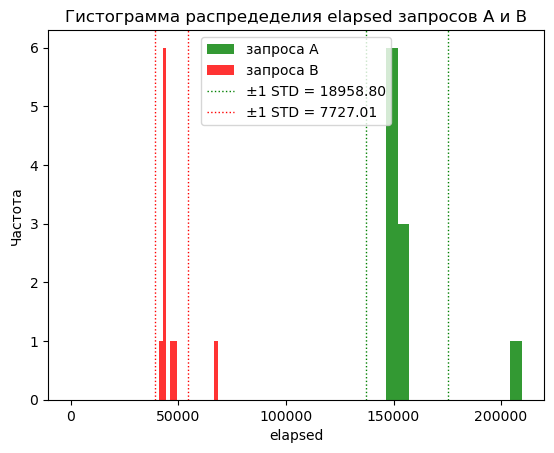

In [167]:
plt.hist(df_a, bins=40, alpha=0.8, range = (0, df_a["elapsed"].max(axis=0)), color='g', label="запроса A")
plt.hist(df_b, bins=40, alpha=0.8, range = (0, df_b["elapsed"].max(axis=0)), color='r', label="запроса B")

plt.axvline(mean_a - std_dev_a, color='green', linestyle='dotted', linewidth=1, label=f'±1 STD = {std_dev_a:.2f}')
plt.axvline(mean_a + std_dev_a, color='green', linestyle='dotted', linewidth=1)

plt.axvline(mean_b - std_dev_b, color='red', linestyle='dotted', linewidth=1, label=f'±1 STD = {std_dev_b:.2f}')
plt.axvline(mean_b + std_dev_b, color='red', linestyle='dotted', linewidth=1)


plt.title('Гистограмма распредеделия elapsed запросов A и B')
plt.xlabel('elapsed')
plt.ylabel('Частота')
plt.legend()

# Показать график
plt.show()

In [57]:
from scipy import stats

In [95]:
shapiro_A = stats.shapiro(df_a)
shapiro_B = stats.shapiro(df_b)

In [93]:
shapiro_A

ShapiroResult(statistic=0.49628496170043945, pvalue=3.289822188889957e-06)

In [97]:
shapiro_B

ShapiroResult(statistic=0.5303599834442139, pvalue=8.27025269245496e-06)

pvalue < 0.05  
Вывод: Данные не распределены нормально

Используем непараметрический тест U-тест Манна-Уитни

In [87]:
u_stat, p_value = stats.mannwhitneyu(df_a, df_b)


In [89]:
u_stat, p_value

(array([100.]), array([0.00018267]))

Интерпретация результата:  
alpha = 0.05  
p_value <= alpha  
0.00018267 < 0.05  
Следовательно, отвергаем нулевую гипотезу, различия между A и B значительны.
Запрос B лучше в плане производительности.


Но у нас есть еще запрос С!

## Проверяем, лучше ли запрос C, чем B:

In [122]:
mean_b = tmean(df_b)
print(f"Среднее значение B: {mean_b:.2f}")
std_dev_b = tstd(df_b)
print(f"Стандартное отклонение B: {std_dev_b[0]:.2f}")

Среднее значение B: 46778.30
Стандартное отклонение B: 7727.01


In [179]:
mean_c = tmean(df_c)
print(f"Среднее значение C: {mean_c:.2f}")
std_dev_c = tstd(df_c)[0]
print(f"Стандартное отклонение C: {std_dev_c:.2f}")

Среднее значение C: 23371.80
Стандартное отклонение C: 3175.88


Вывод: Запрос C лучше, чем запрос B!

## Проверяем значимость результатов сравнения запросов B и C

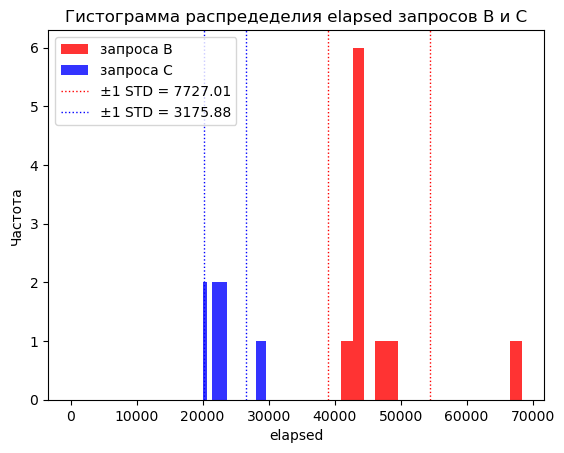

In [181]:
plt.hist(df_b, bins=40, alpha=0.8, range = (0, df_b["elapsed"].max(axis=0)), color='r', label="запроса B")
plt.hist(df_c, bins=40, alpha=0.8, range = (0, df_c["elapsed"].max(axis=0)), color='b', label="запроса C")

plt.axvline(mean_b - std_dev_b, color='red', linestyle='dotted', linewidth=1, label=f'±1 STD = {std_dev_b:.2f}')
plt.axvline(mean_b + std_dev_b, color='red', linestyle='dotted', linewidth=1)

plt.axvline(mean_c - std_dev_c, color='blue', linestyle='dotted', linewidth=1, label=f'±1 STD = {std_dev_c:.2f}')
plt.axvline(mean_c + std_dev_c, color='blue', linestyle='dotted', linewidth=1)


plt.title('Гистограмма распредеделия elapsed запросов B и C')
plt.xlabel('elapsed')
plt.ylabel('Частота')
plt.legend()

# Показать график
plt.show()

In [144]:
from scipy import stats

In [146]:
shapiro_B = stats.shapiro(df_b)
shapiro_C = stats.shapiro(df_c)

In [93]:
shapiro_B

ShapiroResult(statistic=0.49628496170043945, pvalue=3.289822188889957e-06)

In [150]:
shapiro_C

ShapiroResult(statistic=0.7989405393600464, pvalue=0.014074987731873989)

pvalue < 0.05  
Вывод: Данные не распределены нормально

Используем непараметрический тест U-тест Манна-Уитни

In [152]:
u_stat_2, p_value_2 = stats.mannwhitneyu(df_b, df_c)


In [154]:
u_stat_2, p_value_2

(array([100.]), array([0.00018267]))

Интерпретация результата:  
alpha = 0.05  
p_value <= alpha  
0.00018267 < 0.05  
Следовательно, отвергаем нулевую гипотезу, различия между B и C значительны.
Запрос C лучше в плане производительности, чем B.


### Вывод
Мы провели эксперимент, исследовали три sql-запроса в плане производительности, определили самый лучший (им оказался запрос C), 
убедились, что различия между результатами статистически значими.  
Данный кейс не очень показателен, поскольку и при сравнении средних со стандартными отклонениями, и визуально при постороении гистограмм, 
очевидно что победителем является запрос B, но так бывает далеко не всегда.